# Evaluating Gene Correlations - First heart field

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from moscot.problems.time._lineage import TemporalProblem

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path="/home/mgander/moscot-framework_reproducibility/data/mouse_temporal"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [3]:
ct='E8.25:First heart field'
i=11

ts0=ts[i]
ts1=ts[i+1]

In [4]:
gT=np.load(f"{Path}/TOME_maps_growth_rate_and_driver_genes_analysis/{ts0}_{ct}_pull.npy", allow_pickle=True)
gM=np.load(f"{Path}/moscot_maps_growth_rate_and_driver_genes_analysis/{ts0}_{ct}_pull.npy", allow_pickle=True)

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

TOME used the following genes to identify the first heart field cluster: Tbx5, Hcn4, Gata4.

Be careful, I also listed driver/marker genes if there was only moderate evidence of them being directly involved in these cell transitions, so use this list with caution!!!

In [29]:
D={}
D['PMID: 25274757']=['Nkx2-5', 'Gata4', 'Tbx5', 'Smarcd3']

# Isl1 and Tbx1 are SHF-driver genes!!!
#D['PMID: 22072574']=['Isl1', 'Tbx1', 'Tbx5']


D['PMID: 23457256']=['Eomes', 'Mesp1', 'Pdgfra', 'Nkx2-5',  'Bmp2', 'Tbx5', 'Gata4', 
                     'Mef2c', 'Mef2a', 'Smarcd3']
D['PMID: 27194630']=['Tnnt2']
D['PMID: 23743334']=['Hcn4']
D['PMID: 18924235']=['Bmp4', 'Mef2c']
D['PMID: 30288953']=['Hand1', 'Hand2', 'Gata4', 'Mef2c', 'Tbx5']

D['PMID: 29440224']=['Nkx2-5', 'Tbx20', 'Foxf1','Pdgfra', 
                     'Smarcd3', 'Foxa2',  'Bmp4', 'Hdac3', 'Nup155', 'Myod1']

D['PMID: 24123507']=['Irx4']
D['PMID: 17576928']=['Wnt2', 'Wnt7a', 'Wnt8a']
D['PMID: 29985326']=['Actc1']   #Actc1 is pan-cardiac marker
D['PMID: 33585493']=['Tbx20']
D['PMID: 20956536']=['Ccdc141']

D['PMID: 25183852']=['Tbx20', 'Hey2', 'Mycn', 'Nppa', 'Cx40', 'Cdkn1c', 'Bmp10']

# Chicken, so gotta be slighlty careful
#D['PMID: 14991725']=['Popdc2']



# Only in chamber myocardium: Nppa
# Only in AV canal: Tbx2

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [6]:
adata=sc.read(f"{Path}/anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

In [7]:
if 14>i>4:
    ExE_cell_types=['Embryonic visceral endoderm', 'Extraembryonic visceral endoderm', 'Parietal endoderm', 'Extraembryonic ectoderm', 'Primitive erythroid cells', 'Blood progenitors']
    adata=adata[~adata.obs['cell_type'].isin(ExE_cell_types)].copy()
elif i>4:
    ExE_cell_types=['Extraembryonic visceral endoderm']
    adata=adata[~adata.obs['cell_type'].isin(ExE_cell_types)].copy()

In [8]:
#genes=list(adata.var['gene_names'])

In [31]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)
len(genes_selected)

24

In [32]:
[print(a) for a in sorted(genes_selected)]

Actc1
Bmp2
Bmp4
Ccdc141
Cdkn1c
Eomes
Foxa2
Foxf1
Gata4
Hand1
Hand2
Irx4
Mef2c
Mesp1
Mycn
Nkx2-5
Nppa
Pdgfra
Smarcd3
Tbx20
Tbx5
Tnnt2
Wnt2
Wnt8a


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    if gene in [a for a in adata.var.index]:

        loc=adata.var.index.get_loc(gene)
        exp=adata.layers['scvi_normalized'][:,loc]
        #exp=adataS.X[:,loc]
        #exp=np.array(exp.todense()).T[0]
        
        if subset==True:
            wh=np.where(adata.obs['cell_state'].isin(['E8:Splanchnic mesoderm', 'E8:First heart field']))[0]
            #wh=np.where(adata.obs['cell_state'].isin(['E7.75:Splanchnic mesoderm', 'E7.75:First heart field']))[0]
            exp=exp[wh]
            gT2=gT[wh]
            gM2=gM[wh]
        else:
            gT2=gT.copy()
            gM2=gM.copy()


        (cor, p)=scipy.stats.spearmanr(exp, gT2)
        dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        (cor, p)=scipy.stats.spearmanr(exp, gM2)
        dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

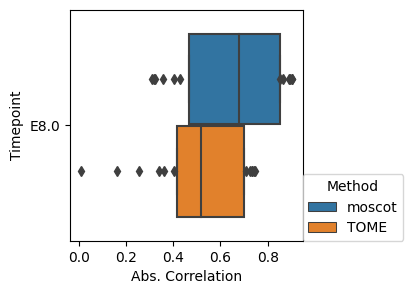

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
g=sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)
sns.move_legend(g,(1,0))

In [19]:
DF.to_pickle(f'{Path}/Validation_output/{ts0}_FHF.npy')